In [2]:
!pip3 install psycopg2-binary pandas scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 385 kB 850 kB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /Library/Developer/CommandLineTools/usr/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/pip-install-k30lr2ha/psycopg2-binary_eaf7cdea46be43ba8bd68b9dac24aed6/setup.py'"'"'; __file__='"'"'/private/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/pip-install-k30lr2ha/psycopg2-binary_eaf7cdea46be43ba8bd68b9dac24aed6/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/pip-pip-egg-info-wrxk852d
         cwd:

In [9]:

import pandas as pd
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="farm",
    user="dm",
    password="dm123",
)

sql = """
WITH salary_per_year AS (
    SELECT farm_id,
           EXTRACT(YEAR FROM hire_date)::int AS year,
           SUM(salary + COALESCE(bonus,0))      AS total_salary
    FROM   Employee
    GROUP  BY farm_id, year
),
equipment_per_year AS (
    SELECT farm_id,
           EXTRACT(YEAR FROM CURRENT_DATE)::int AS year,
           SUM(maintenance_cost_per_year)       AS total_equipment_maintenance
    FROM   Equipment
    GROUP  BY farm_id
),
fertilizer_per_year AS (
    SELECT l.farm_id,
           EXTRACT(YEAR FROM fu.date)::int      AS year,
           SUM(fu.amount_kg * f.price_per_kg)   AS total_fertilizer_cost
    FROM   FertilizerUsage fu
    JOIN   Fertilizer f ON f.fertilizer_id = fu.fertilizer_id
    JOIN   LandPlot   l ON l.plot_id      = fu.plot_id
    GROUP  BY l.farm_id, year
),
crop_income_per_year AS (
    SELECT l.farm_id,
           EXTRACT(YEAR FROM p.harvest_date)::int          AS year,
           SUM(c.yield * 1000 * c.market_price_per_kg
               * l.area)                                   AS total_income
    FROM   Planting  p
    JOIN   LandPlot  l ON l.plot_id = p.plot_id
    JOIN   Crop      c ON c.crop_id = p.crop_id
    GROUP  BY l.farm_id, year
)

SELECT
    COALESCE(s.farm_id,e.farm_id,f.farm_id,i.farm_id) AS farm_id,
    COALESCE(s.year,e.year,f.year,i.year)             AS year,
    COALESCE(total_salary,0)                 AS total_salary,
    COALESCE(total_equipment_maintenance,0)  AS total_equipment_maintenance,
    COALESCE(total_fertilizer_cost,0)        AS total_fertilizer_cost,
    COALESCE(total_income,0)                 AS total_income,
    (COALESCE(total_salary,0)
     + COALESCE(total_equipment_maintenance,0)
     + COALESCE(total_fertilizer_cost,0))    AS total_expenses,
    (COALESCE(total_income,0)
     - (COALESCE(total_salary,0)
        + COALESCE(total_equipment_maintenance,0)
        + COALESCE(total_fertilizer_cost,0))) AS profit
FROM salary_per_year s
FULL JOIN equipment_per_year  e ON s.farm_id=e.farm_id AND s.year=e.year
FULL JOIN fertilizer_per_year f ON COALESCE(s.farm_id,e.farm_id)=f.farm_id
                                AND COALESCE(s.year,e.year)=f.year
FULL JOIN crop_income_per_year i ON COALESCE(s.farm_id,e.farm_id,f.farm_id)=i.farm_id
                                 AND COALESCE(s.year,e.year,f.year)=i.year
ORDER BY farm_id, year;
"""

df_yearly = pd.read_sql(sql, conn)

print(df_yearly.head())


   farm_id  year  total_salary  total_equipment_maintenance  \
0        1  2010      10116.22                          0.0   
1        1  2013      46042.85                          0.0   
2        1  2014      28041.33                          0.0   
3        1  2015      11433.67                          0.0   
4        1  2017      48274.31                          0.0   

   total_fertilizer_cost  total_income  total_expenses    profit  
0                    0.0           0.0        10116.22 -10116.22  
1                    0.0           0.0        46042.85 -46042.85  
2                    0.0           0.0        28041.33 -28041.33  
3                    0.0           0.0        11433.67 -11433.67  
4                    0.0           0.0        48274.31 -48274.31  


/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/ipykernel_11054/1681590381.py:70: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yearly = pd.read_sql(sql, conn)


In [14]:
df_yearly[6:10]

,farm_id,year,total_salary,total_equipment_maintenance,total_fertilizer_cost,total_income,total_expenses,profit
6,1,2020,36811.00,0.0,4385.8179,1831643.398,41196.8179,1.790447e+06
7,1,2021,56728.24,0.0,10795.9806,2981101.628,67524.2206,2.913577e+06
8,1,2022,15635.57,0.0,14234.9626,2303824.856,29870.5326,2.273954e+06
9,1,2023,19566.45,0.0,13919.6114,2782439.170,33486.0614,2.748953e+06


In [10]:

soil_sql = """
SELECT lp.soil_type,
       c.name AS crop_name,
       c.yield                    AS yield_tonnes,
       c.seed_cost_per_hectare,
       f.price_per_kg,
       fu.amount_kg,
       fu.amount_kg * f.price_per_kg                     AS fertilizer_cost,
       (c.yield * 1000 * c.market_price_per_kg)          AS revenue_per_hectare,
       (c.seed_cost_per_hectare + fu.amount_kg * f.price_per_kg) AS total_cost,
       ((c.yield * 1000 * c.market_price_per_kg)
        - (c.seed_cost_per_hectare + fu.amount_kg * f.price_per_kg)) AS profit_per_hectare
FROM   LandPlot lp
JOIN   Planting       p  ON p.plot_id = lp.plot_id
JOIN   Crop           c  ON c.crop_id = p.crop_id
JOIN   FertilizerUsage fu ON fu.plot_id = lp.plot_id
JOIN   Fertilizer     f  ON f.fertilizer_id = fu.fertilizer_id;
"""

df_plot = pd.read_sql(soil_sql, conn)

top_thr = df_plot["profit_per_hectare"].quantile(0.90)
df_plot["top_crop"] = df_plot["profit_per_hectare"] >= top_thr


/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/ipykernel_11054/1907970412.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_plot = pd.read_sql(soil_sql, conn)


Accuracy on test: 96.37%


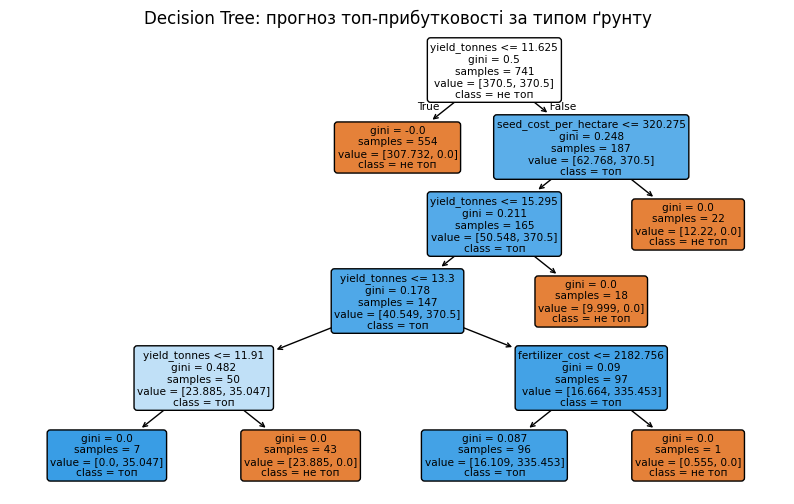

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

le_soil = LabelEncoder()
df_plot["soil_enc"] = le_soil.fit_transform(df_plot["soil_type"])

feat_cols = ["soil_enc", "seed_cost_per_hectare", "fertilizer_cost", "yield_tonnes"]

X = df_plot[feat_cols]
y = df_plot["top_crop"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

tree = DecisionTreeClassifier(
    max_depth=5,
    class_weight="balanced",
    random_state=42,
)
tree.fit(X_train, y_train)

print(f"Accuracy on test: {tree.score(X_test, y_test):.2%}")

plt.figure(figsize=(10, 6))
plot_tree(
    tree,
    feature_names=feat_cols,
    class_names=["не топ", "топ"],
    filled=True,
    rounded=True,
)
plt.title("Decision Tree: прогноз топ-прибутковості за типом ґрунту")
plt.show()


In [17]:
top_soils = (
    df_plot.groupby("soil_type")["top_crop"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("Топ ґрунти за часткою прибуткових культур:")
print(top_soils)


Топ ґрунти за часткою прибуткових культур:
    soil_type  top_crop
0        Silt  0.305085
1        Clay  0.122642
2  Loamy sand  0.119760
3    Alluvial  0.100000
4        Loam  0.077844
5       Sandy  0.075000
6   Chernozem  0.055901
7       Peaty  0.050505


/var/folders/5c/8j0jzx8d1jj25hvgcjf5jyl40000gp/T/ipykernel_11054/2294331929.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_soils, x="soil_type", y="top_crop", palette="viridis")


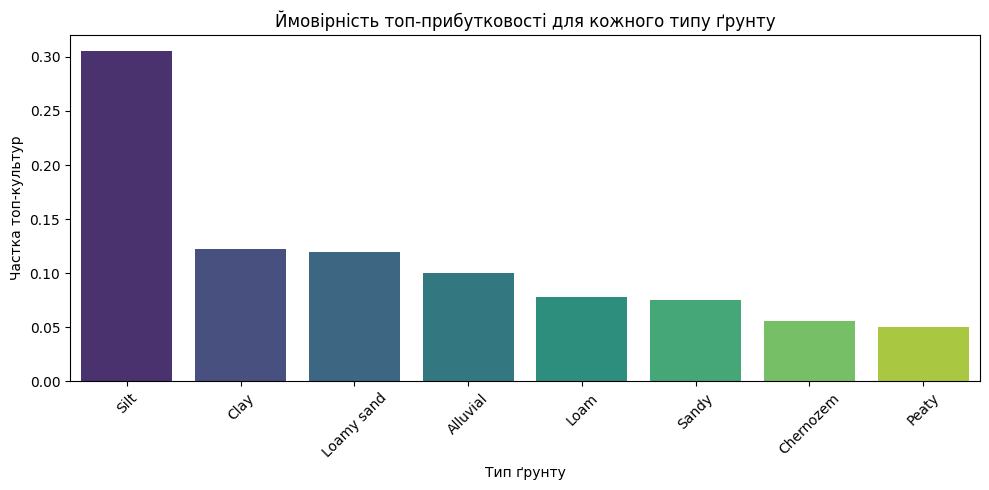

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=top_soils, x="soil_type", y="top_crop", palette="viridis")
plt.xticks(rotation=45)
plt.title("Ймовірність топ-прибутковості для кожного типу ґрунту")
plt.ylabel("Частка топ-культур")
plt.xlabel("Тип ґрунту")
plt.tight_layout()
plt.show()


         yield_tonnes  seed_cost_per_hectare  amount_kg  fertilizer_cost  \
cluster                                                                    
0                5.33                 209.69     173.89           430.06   
1                7.16                 196.37     390.25          1216.04   
2               13.16                 204.93     248.14           638.16   

         profit_per_hectare  
cluster                      
0                   4597.71  
1                   5778.63  
2                  19273.70  


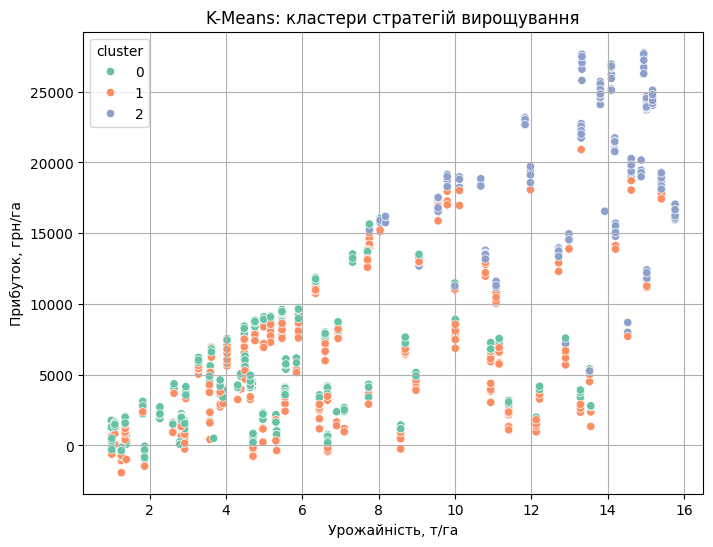

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

feat_cols = [
    "yield_tonnes",
    "seed_cost_per_hectare",
    "amount_kg",  # добриво
    "fertilizer_cost",
    "profit_per_hectare",
]

X_num = df_plot[feat_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
df_plot["cluster"] = kmeans.fit_predict(X_scaled)

print(df_plot.groupby("cluster")[feat_cols].mean().round(2))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="yield_tonnes",
    y="profit_per_hectare",
    hue="cluster",
    palette="Set2",
)
plt.title("K-Means: кластери стратегій вирощування")
plt.xlabel("Урожайність, т/га")
plt.ylabel("Прибуток, грн/га")
plt.grid(True)
plt.show()


# Лабораторна робота №6  
**Прескриптивний аналіз даних**

## Мета роботи

Виконати прескриптивний аналіз для сільськогосподарських даних з метою:
- Визначити, які фактори (тип ґрунту, витрати, урожайність) впливають на прибутковість
- Побудувати модель, яка підказує, коли культура має високий шанс стати прибутковою
- Виділити типові стратегії вирощування сільськогосподарських культур (кластеризація)

---

## Дані

Дані були отримані з бази PostgreSQL (8 таблиць, ~1000 записів) та агреговані у два набори:
- `df_plot` — дані по ділянках: тип ґрунту, витрати, урожайність, прибуток
- `df_yearly` — агреговані витрати/дохід по роках (не використовувались безпосередньо у класифікації)

---

## Моделі та методи

### 1. Decision Tree (дерево рішень)

- Побудоване на ознаках:
  - `soil_type`
  - `yield_tonnes`
  - `seed_cost_per_hectare`
  - `fertilizer_cost`
- Цільова змінна: `top_crop` — чи входить у 10% найприбутковіших культур

**Результат:**
- Точність: **96.37%**
- Модель виявила, що критичним фактором є **урожайність**: якщо вона перевищує ~11.6 т/га — ймовірність «топу» зростає
- Також важливим є рівень витрат на добрива

**Висновок:** модель дозволяє **приймати рішення**, коли доцільно вирощувати певну культуру на певній ділянці.

---

### 2. Аналіз типів ґрунтів

- Для кожного типу ґрунту обчислена **ймовірність входження у топ-прибуткові культури**
- Візуалізовано у вигляді barplot

**Результат:**
- Топ-3 ґрунти:  
  - `Silt` — **30.5%**
  - `Clay` — **12.3%**
  - `Loamy sand` — **11.9%**

**Висновок:** агрономи можуть пріоритезувати `Silt` як найбільш прибутковий для культивування топ-культур.

---

### 3. Кластеризація (KMeans)

- Використано ознаки:
  - `yield_tonnes`
  - `seed_cost_per_hectare`
  - `amount_kg`
  - `fertilizer_cost`
  - `profit_per_hectare`

- Визначено **3 кластери** стратегій вирощування:
  - Кластер 0 — низька урожайність, низький прибуток
  - Кластер 1 — середній ризик / прибутковість
  - Кластер 2 — **висока урожайність і прибуток**

**Висновок:** фермер може орієнтуватись на характеристики кластеру 2, щоб **перейти в більш прибуткову групу** через збільшення витрат на насіння чи добрива.

---

## Висновки

- **Прескриптивний аналіз** дозволив сформулювати **чіткі поради**:
  - Вирощування на ґрунтах `Silt` значно підвищує ймовірність високого прибутку
  - Культури з урожайністю понад 11.6 т/га та контрольованими витратами мають високий шанс успіху
  - Перехід від кластеру 0 до 2 можливий через збільшення добрив і витрат на насіння

- Ці висновки можуть використовуватись для **оптимізації прийняття рішень в аграрному секторі**.

---

**Виконав:** Коваль Денис  
**Група:** ШІ-32  
**Викладач:** Кошлатий В. А.  
**Львів – 2025**